## Цель работы:
Определить LTV пользователя

## Описание данных:
start_dt — дата старта визита

start_ts — дата и время старта визита

end_ts — дата окончания визита

uid — идентификатор пользователя

source_id — id источника визита

device — устройство

buy_ts — дата и время покупки

revenue — доход в y.e.

## 1. Файл с данными и общая информация

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings

In [271]:
visits = pd.read_csv('visits.csv', sep='\t') # загружаем датасет visits
visits.head()

,device,end_ts,source_id,start_dt,start_ts,uid
0,desktop,2016-11-30T11:04:17Z,2,2016-11-30,2016-11-30T10:53:49Z,3758486201
1,desktop,2016-11-10T23:16:57Z,4,2016-11-10,2016-11-10T23:08:04Z,2933941628
2,desktop,2016-10-19T18:51:56Z,1,2016-10-19,2016-10-19T18:48:16Z,1465872791
3,desktop,2017-01-12T20:51:55Z,9,2017-01-12,2017-01-12T20:50:10Z,2751875787
4,touch,2016-07-23T19:17:19Z,4,2016-07-23,2016-07-23T19:10:57Z,3492372810


In [272]:
purchases = pd.read_csv('purchases.csv', sep='\t') # загружаем датасет purchases
purchases.head()

,buy_ts,uid,revenue
0,23.07.2016 19:13:54,3492372810,"1,47"
1,06.11.2016 02:48:27,1564753091,"1,11"
2,31.01.2017 20:32:42,1385616391,"16,8"
3,11.01.2017 10:52:11,2636761148,11
4,25.11.2016 18:57:09,2945629974,"4,89"


In [273]:
visits.info() # смотрим общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     720679 non-null  object
 1   end_ts     720679 non-null  object
 2   source_id  720679 non-null  int64 
 3   start_dt   720679 non-null  object
 4   start_ts   720679 non-null  object
 5   uid        720679 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 33.0+ MB


In [274]:
purchases.info() # смотрим общую информацию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   buy_ts   75716 non-null  object
 1   uid      75716 non-null  int64 
 2   revenue  75716 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


## Вывод:
Датафрейм visits состоит из 720679 строк и 6 столбцов

Датафрейм purchases состоит из 75716 строк и 3 столбцов

Пропусков в датафремах нету

Видно, что столбец revenue имеет тип object и число форматом (X,X), в дальнейшей работе поменяем (, на .) и тип данных на float64

Также в visits столбцы end_ts и start_ts нужно преобразовать в формат datetime64

## 2. Преобразование данных в нужный тип

In [275]:
purchases['revenue'] = purchases['revenue'].str.replace(',', '.') # заменяем запятую на точку

In [276]:
purchases['revenue'] = pd.to_numeric(purchases['revenue'], errors='raise') # преобразуем object в float

In [277]:
purchases.info() # проверяем преобразование

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75716 entries, 0 to 75715
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   75716 non-null  object 
 1   uid      75716 non-null  int64  
 2   revenue  75716 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [278]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')

In [313]:
visits['session_year']  = visits['start_ts'].values.astype('datetime64[Y]')  #cоздаем столбец с годом
visits['session_month'] = visits['start_ts'].values.astype('datetime64[M]')  #cоздаем столбец с месяцем

In [280]:
visits.info() # проверяем преобразование

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720679 entries, 0 to 720678
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   device         720679 non-null  object             
 1   end_ts         720679 non-null  datetime64[ns, UTC]
 2   source_id      720679 non-null  int64              
 3   start_dt       720679 non-null  object             
 4   start_ts       720679 non-null  datetime64[ns, UTC]
 5   uid            720679 non-null  int64              
 6   session_year   720679 non-null  datetime64[ns]     
 7   session_month  720679 non-null  datetime64[ns]     
dtypes: datetime64[ns, UTC](2), datetime64[ns](2), int64(2), object(2)
memory usage: 44.0+ MB


In [281]:
purchases['buy_ts'] = purchases['buy_ts'].astype('datetime64[M]')

## 3. Расчет LVT

LVT = revenue * margin_rate / n_buyers, где

- revenue - выручка
- margin_rate - частоту повторных покупок
- n_buyers - количество уникальных покупателей

Расчитаем LTV с помощью когортного анализа. 

In [282]:
first_purchases = purchases.groupby('uid').agg({'buy_ts': 'min'}).reset_index() #группируем таблицу с датой покупки
first_purchases.columns = ['uid', 'first_buy_month'] #создаем название столбцов
first_purchases.head() 

,uid,first_buy_month
0,157352,2016-06-01
1,256370,2016-06-01
2,308857,2016-06-01
3,352142,2017-02-01
4,445960,2016-10-01


In [283]:
cohort_sizes = first_purchases.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index() #группируем таблицу с количеством покупателя в каждом месяце
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
purchases_new = pd.merge(purchases,first_purchases, on='uid') #объединяем таблицу purchases с first_purchases
purchases_new.head()

,buy_ts,uid,revenue,first_buy_month
0,2016-07-01,3492372810,1.47,2016-07-01
1,2017-04-01,3492372810,0.49,2016-07-01
2,2016-06-01,1564753091,1.11,2016-06-01
3,2017-01-01,1385616391,16.80,2017-01-01
4,2017-11-01,2636761148,11.00,2016-06-01


In [284]:
cohorts = purchases_new.groupby(['first_buy_month','buy_ts']).agg({'revenue': 'sum'}).reset_index() #группируем таблицу по первому месяцу, месяцу заказа и суммы покупки
cohorts.head()

,first_buy_month,buy_ts,revenue
0,2016-01-01,2016-01-01,5835.27
1,2016-01-01,2016-02-01,1076.49
2,2016-01-01,2016-03-01,712.10
3,2016-01-01,2016-04-01,1270.21
4,2016-01-01,2016-05-01,1205.27


In [285]:
data = pd.merge(cohort_sizes, cohorts, on='first_buy_month') #создаем отдельны датасет для удобства
data.head()

,first_buy_month,n_buyers,buy_ts,revenue
0,2016-01-01,1103,2016-01-01,5835.27
1,2016-01-01,1103,2016-02-01,1076.49
2,2016-01-01,1103,2016-03-01,712.10
3,2016-01-01,1103,2016-04-01,1270.21
4,2016-01-01,1103,2016-05-01,1205.27


In [286]:
margin_rate = 1 #частоту повторных покупок делаем равной 1, тк. точных данных нет

In [287]:
data['gp'] = data['revenue'] * margin_rate #расчет валовой прибыли
data['gp']

0      5835.27
1      1076.49
2       712.10
3      1270.21
4      1205.27
        ...   
295      27.71
296      16.83
297    2705.22
298      60.37
299    2812.02
Name: gp, Length: 300, dtype: float64

In [288]:
data['age'] = (data['buy_ts'] - data['first_buy_month']) / np.timedelta64(1, 'M') #расчет среднего возраста
data['age'] = data['age'].round().astype('int')
data['age'].mean()

7.666666666666667

In [289]:
data['ltv'] = data['gp'] / data['n_buyers'] #расчет LTV
data['ltv']

0      5.290363
1      0.975966
2      0.645603
3      1.151596
4      1.092720
         ...   
295    0.039642
296    0.024077
297    4.068000
298    0.090782
299    4.286616
Name: ltv, Length: 300, dtype: float64

In [290]:
output = data.pivot_table(       
        index='first_buy_month',
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2).cumsum(axis = 1)
#Формирование итоговой таблицы

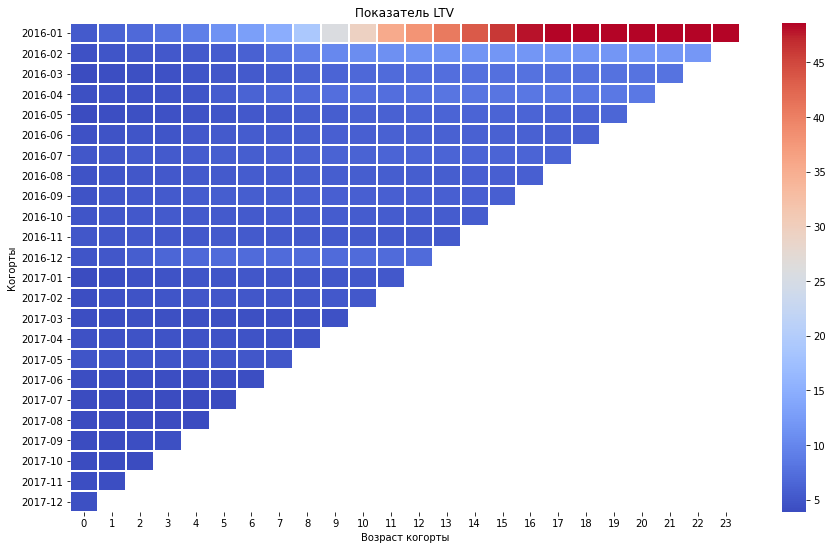

In [291]:
plt.figure(figsize=(15, 9))
plt.title('Показатель LTV')
x = pd.DataFrame({'month': output.index})
x = x['month'].apply(lambda x: x.strftime("%Y-%m")).to_list()
sns.heatmap(output, robust=True, fmt='.1f', linewidths=1, linecolor='white', cmap="coolwarm", yticklabels=x)
plt.ylabel('Когорты')
plt.xlabel('Возраст когорты')
plt.show()
#тепловая диаграмма

In [292]:
cohort_ltv_mean = float(output[[5]].head(7).mean())
print('Среднее LTV за 6 месяцев состовляет: {:.2f}'.format(cohort_ltv_mean))

Среднее LTV за 6 месяцев состовляет: 6.23


## Вывод:
С помощью когортного анализа, смогли посчитать средний LTV пользователя за 6 месяцев, который равен 6.23

## 3. Рекомендации по улучшению LTV

#### Посчитаем среднее количество пользователей за месяц и сравним их количество на разных устройствах:

In [314]:
month = visits.groupby(['device', 'session_year', 'session_month']).agg({'uid': 'nunique'})
month = month.pivot_table(index='session_month', columns='device', values='uid')
month_desk = month['desktop'].mean()
month_touch = month['touch'].mean()

print('Среднее количество уникальных пользователей для ПК в месяц: {:.2f}'.format(month_desk))
print('Среднее количество уникальных пользователей для смартфонов в месяц: {:.2f}'.format(month_touch))

Среднее количество уникальных пользователей для ПК в месяц: 29737.33
Среднее количество уникальных пользователей для смартфонов в месяц: 12368.08


In [315]:
visits['duration_ses'] = (visits['end_ts'] - visits['start_ts']) / np.timedelta64(1,'s')

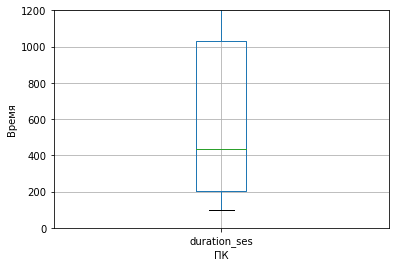

In [316]:
visits.query('device =="desktop"').boxplot('duration_ses') #бохплот для ПК
plt.ylim(0, 1200)
plt.xlabel('ПК')
plt.ylabel('Время')
plt.show()

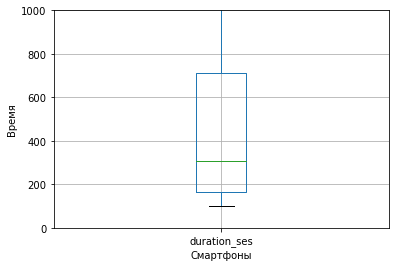

In [317]:
visits.query('device =="touch"').boxplot('duration_ses') #бохплот для смартфонов
plt.ylim(0, 1000)
plt.xlabel('Смартфоны')
plt.ylabel('Время')
plt.show()

In [318]:
visits_med = visits['duration_ses'].median()
visits_dec = visits.query('device == "desktop"')['duration_ses'].median()
visits_touch = visits.query('device == "touch"')['duration_ses'].median()

print('Медианна общих сессий: {:.0f} сек'.format(visits_med))
print('Медианна ПК сессий: {:.0f} сек'.format(visits_dec))
print('Медианна смартфон сессий: {:.0f} сек'.format(visits_touch))

Медианна общих сессий: 395 сек
Медианна ПК сессий: 438 сек
Медианна смартфон сессий: 308 сек


In [320]:
visits_mean = visits['duration_ses'].mean()
visits_dec_mean = visits.query('device == "desktop"')['duration_ses'].mean()
visits_touch_mean = visits.query('device == "touch"')['duration_ses'].mean()

print('Общая средняя продолжительность сессий: {:.0f} сек'.format(visits_mean))
print('Средняя продолжительность ПК сессий: {:.0f} сек'.format(visits_dec_mean))
print('Средняя продолжительность смартфон сессий: {:.0f} сек'.format(visits_touch_mean))

Общая средняя продолжительность сессий: 754 сек
Средняя продолжительность ПК сессий: 816 сек
Средняя продолжительность смартфон сессий: 587 сек


## Вывод:

Среднее количество пользователей ПК в месяц больше, чем пользователей смартфонов, практически в 2.5 раза. Это объясняется тем, что пользоваться сервисом удобнее на ПК, чем мобильной версией.

Средняя продолжительность сессий состовляет 754 сек.. У ПК версии среднее значение больше общего, а у мобильной версии меньше общего. Можно сделать вывод, что пользователи на ПК смогут точно произвести конверсию, в отличие от мобильной версии.

Медианное значение показывает, что распределение значений неравномерно.



## Рекомендации:

Из анализа пользователей и средней сессии удалось вычислить, что пользователей ПК версии больше в 2.5 раза. Предлагаю поработать над мобильной версией продукта, а именно UI/UX интерфейсом, так-как было определено, что версия для ПК гораздо удобнее и средняя продолжительность сессии занимает 816 сек, а мобильная версии 587 сек, что меньше общей средней продолжительной сессиии. Стоит провести CustDev и узнать у пользователей, что именно им не нравится и об их опыте работы с данным продуктом.